In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        done = False
        while not done:
            action_probs = policy(state)
            action = np.random.choice(np.arange(env.nA), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            Q[state][action] += alpha*(reward+discount_factor*np.max(Q[next_state])-Q[state][action])
            state = next_state
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] += 1
    
    return Q, stats

In [7]:
Q, stats = q_learning(env, 500)

Episode 500/500.

In [9]:
Q

defaultdict(<function __main__.q_learning.<locals>.<lambda>()>,
            {36: array([-13.        , -99.99389648, -13.99952915, -13.99887309]),
             24: array([-13.71888942, -12.        , -13.99931157, -12.99952153]),
             12: array([-12.98717715, -12.79758769, -12.88659772, -12.83829308]),
             0: array([-12.5776329 , -12.37228407, -12.85191693, -12.41480637]),
             1: array([-11.60990246, -11.6642772 , -11.93473068, -11.92951704]),
             2: array([-11.17860863, -10.85754754, -11.3032383 , -11.11202963]),
             3: array([-10.25      , -10.11944279, -10.29167759, -10.50463488]),
             4: array([-9.5       , -9.36654101, -9.33064652, -9.69752131]),
             16: array([ -9.96077826,  -8.99577513,  -8.99664686, -10.03862947]),
             5: array([-8.5       , -8.49441083, -8.46651851, -9.22704304]),
             6: array([-7.80066681, -7.61223553, -7.79036596, -8.15330662]),
             7: array([-7.        , -6.70437993, -6.8

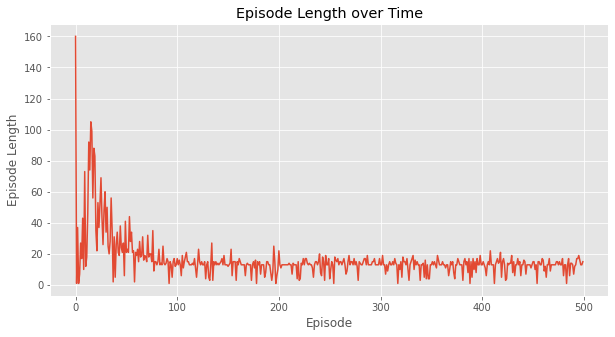

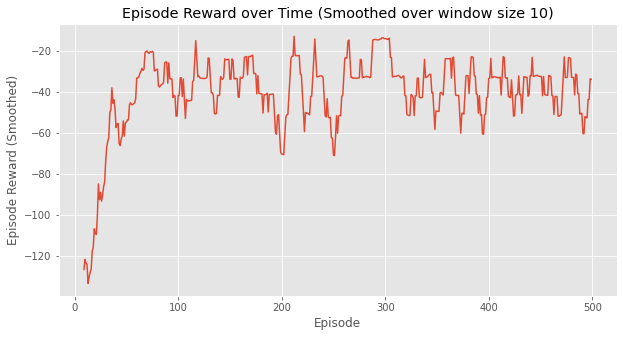

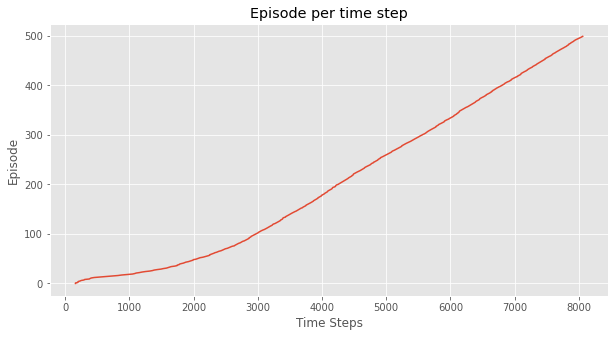

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [8]:
plotting.plot_episode_stats(stats)